This is about visualising the indicators like RSI,MACD,etc. and understanding the signals given by them.
The ticker symbol used for illustration is 'ITC.NS' (2 year data extracted from Yahoo Finance).

In [13]:
import pandas as pd
import numpy as np
import datetime
from getdata import fetch_extended_data
from sma import SMAs
from rsi import RSI
from macd import EMA,MACD
import matplotlib as mt
from matplotlib import pyplot as plt

#Data extract
start='2022-05-01'
end='2024-05-01'
prices=fetch_extended_data('ITC.NS','Close',50,start,end)


[*********************100%%**********************]  1 of 1 completed


In [14]:
##Calculation
plt.figure(figsize=(14, 7))
fast_sma=SMAs(prices)[0].loc[prices.index>start]
slow_sma=SMAs(prices)[1].loc[prices.index>start]
rsi=RSI(prices).loc[prices.index>start]
macd=MACD(prices)[0].loc[prices.index>start]
signal=MACD(prices)[1].loc[prices.index>start]
hist=MACD(prices)[2].loc[prices.index>start]
prices=prices.loc[prices.index>start]
start=pd.to_datetime(start)
end=pd.to_datetime(end)


<Figure size 1400x700 with 0 Axes>

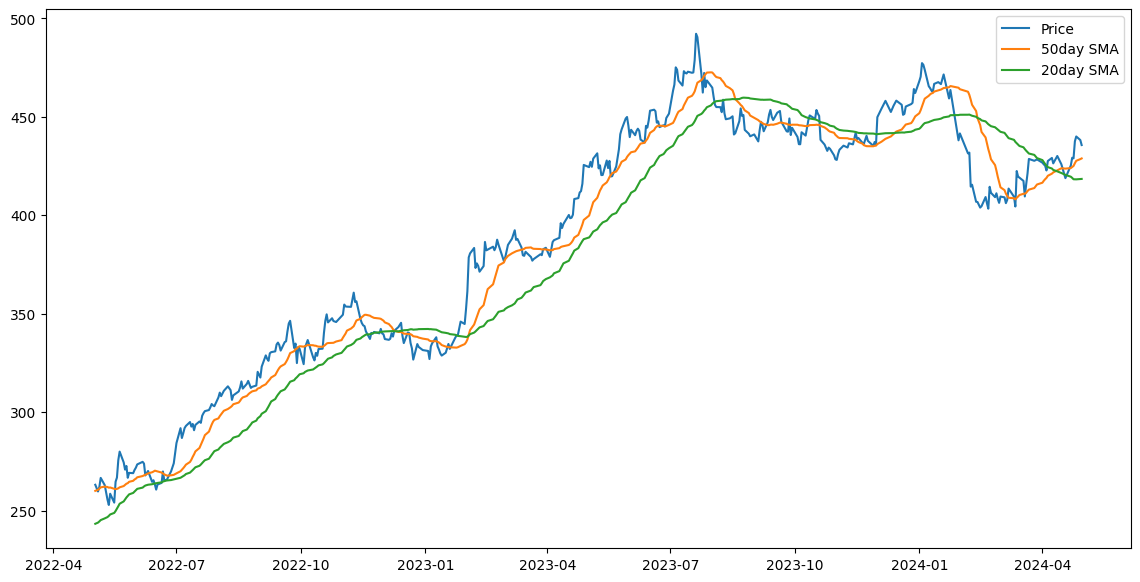

In [15]:
##SMA
plt.figure(figsize=(14, 7))
plt.plot(prices,label="Price")
plt.plot(fast_sma,label="50day SMA")
plt.plot(slow_sma,label="20day SMA")
plt.plot()
plt.legend()
plt.show()


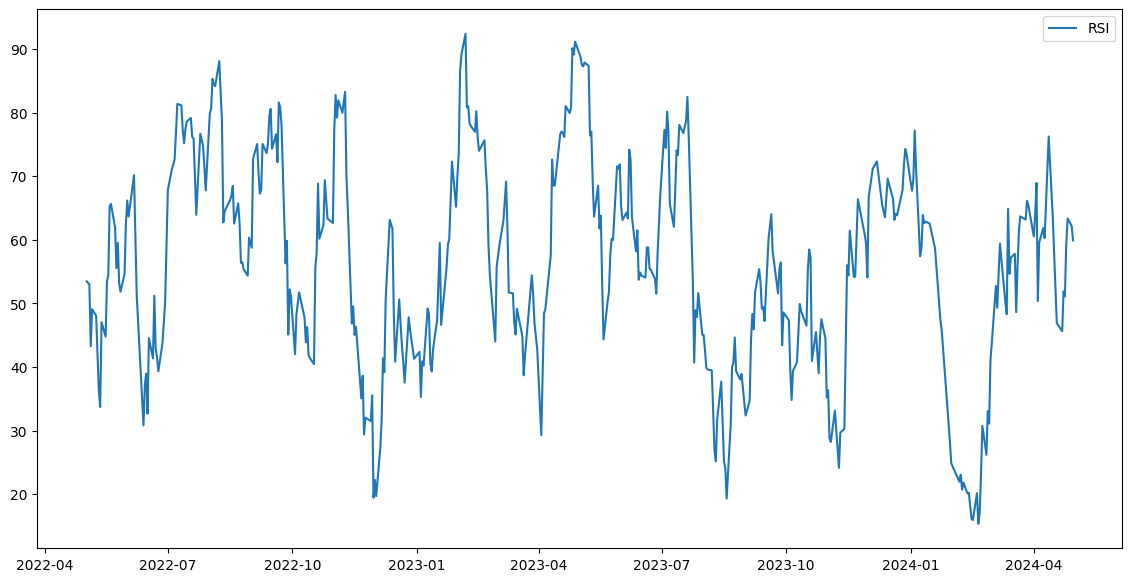

In [16]:
##RSI
plt.figure(figsize=(14, 7))
plt.plot(rsi,label="RSI")
plt.plot()
plt.legend()
plt.show()

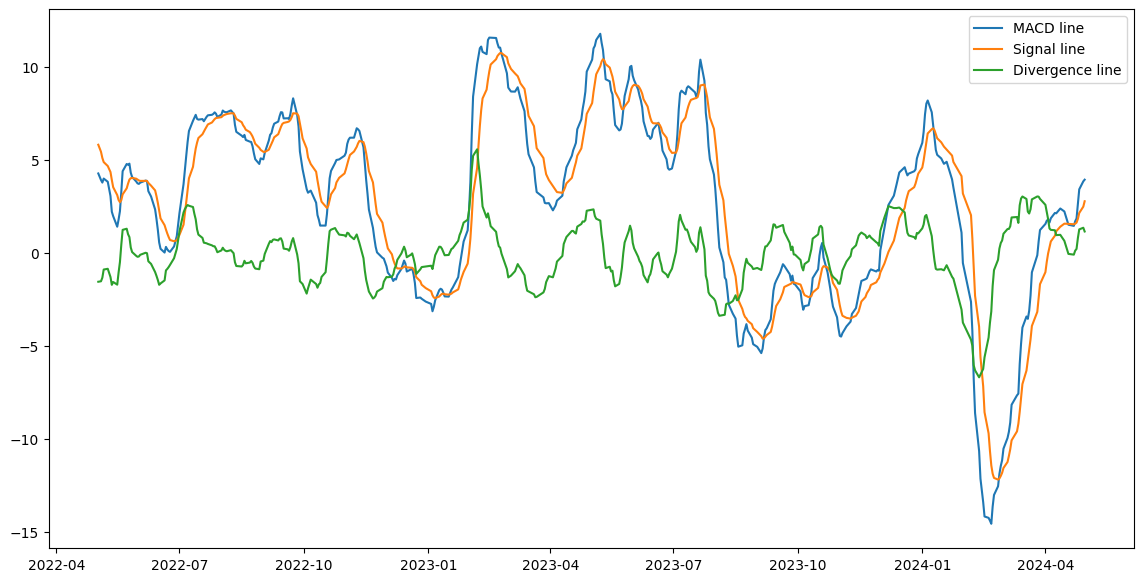

In [17]:
##MACD
plt.figure(figsize=(14, 7))
plt.plot(macd,label="MACD line")
plt.plot(signal,label="Signal line")
plt.plot(hist,label="Divergence line")

plt.plot()
plt.legend()
plt.show()

Now we will see how the indicators are going to be used. We are going to apply our trading strategies based on each indicator and try to visualise how the trades are going to be executed.

1.SMA

In [18]:
def backtest_strategy(prices, short_ma, long_ma):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['short_ma'] = short_ma
    signals['long_ma'] = long_ma
    signals['signal'] = 0
    signals.loc[short_ma > long_ma,'signal'] = 1
    signals.loc[short_ma <= long_ma,'signal'] = 0
    signals['positions'] = signals['signal'].diff()
    return signals

def plot_signals(signals):
    
    plt.figure(figsize=(14, 7))
    plt.plot(signals['price'], label='Price')
    plt.plot(signals['short_ma'], label='20-day MA')
    plt.plot(signals['long_ma'], label='50-day MA')
    plt.plot(signals[signals['positions'] == 1].index, signals['price'][signals['positions'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(signals[signals['positions'] == -1].index, signals['price'][signals['positions'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.legend()
    plt.show()

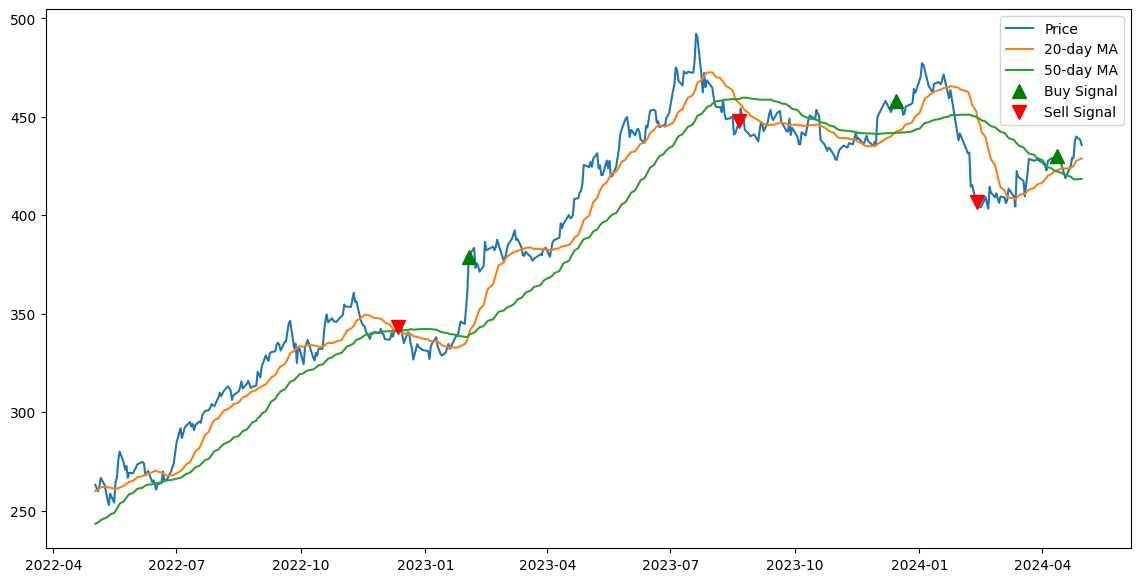

In [19]:

signals = backtest_strategy(prices, fast_sma, slow_sma)
plot_signals(signals)


In the above chart, we can see the sell points when 50day SMA becomes greater than 20day SMA and vice-versa for buy points.

2.RSI  
So how to use RSI values?
- We will consider the stock __OVERBOUGHT__ if RSI>75 and __OVERSOLD__ if RSI<28. And trade accordingly.
Later on, we will try out differnt value of these boundaries and check which one give better returns.
- It gives strong signals during sideways and non-trending ranges.

In [30]:
def backtest_rsi(prices,rsi):
    signals = pd.DataFrame(index=prices.index)
    signals['prices'] = prices
    signals['rsi'] = rsi
    signals['signal'] = 0
     # Initial state
    current_signal = 0
    
    for i in range(1, len(rsi)):
        if current_signal == 0 and rsi.iloc[i] > 75:
            current_signal = 1
        elif current_signal == 1 and rsi.iloc[i] < 28:
            current_signal = 0
        signals.loc[signals.index[i], 'signal'] = current_signal
    signals['positions'] = signals['signal'].diff()
    return signals
    
def plot_rsi_signals(signals):
    
    plt.figure(figsize=(14, 5))
    plt.plot(signals['prices'], label='Price')
    plt.plot(signals[signals['positions'] == -1].index, signals['prices'][signals['positions'] == -1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(signals[signals['positions'] == 1].index, signals['prices'][signals['positions'] == 1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.legend()
    plt.show()

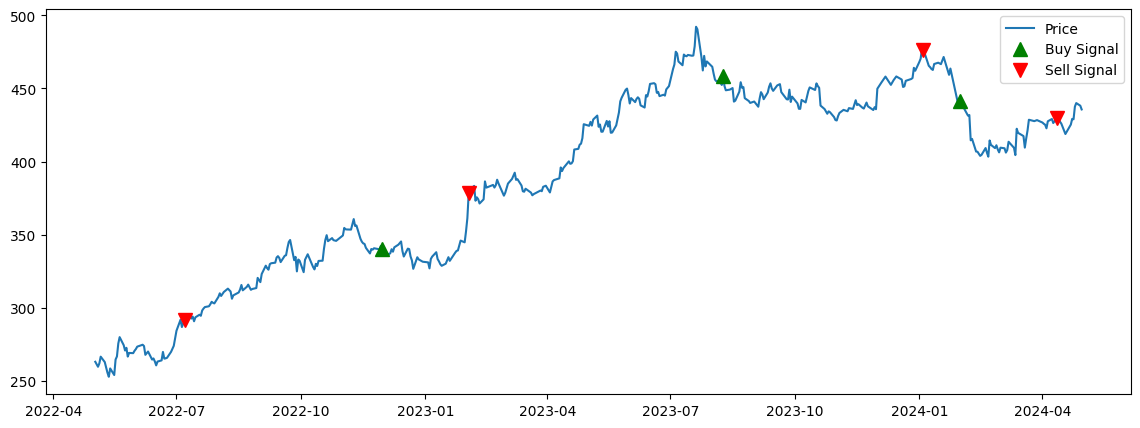

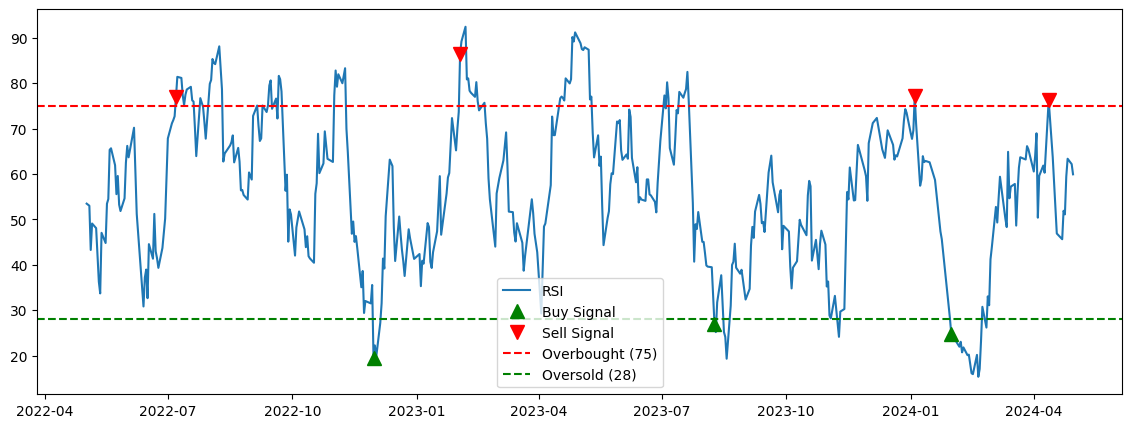

In [31]:
signals=backtest_rsi(prices,rsi)
plot_rsi_signals(signals)
plt.figure(figsize=(14, 5))
plt.plot(rsi,label="RSI")
plt.plot(signals[signals['positions'] == -1].index, signals['rsi'][signals['positions'] == -1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(signals[signals['positions'] == 1].index, signals['rsi'][signals['positions'] == 1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.axhline(y=75, color='r', linestyle='--', label='Overbought (75)')
plt.axhline(y=28, color='g', linestyle='--', label='Oversold (28)')
plt.legend()
plt.show()

3.MACD
- We are using 12 day-26 day model of MACD. When the MACD lines goes above the signal line, it is considered a good chance of buying and vice-versa for selling.
- Useful for strong trends.

In [22]:
def backtest_strategy(prices, hist):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['hist'] = hist          #hist is macd-signal
    signals['signal'] = 0
    signals.loc[hist>0,'signal'] = 1
    signals.loc[hist<=0,'signal'] = 0
    signals['positions'] = signals['signal'].diff()
    return signals

def plot_signals(signals):
    
    plt.figure(figsize=(14, 5.5))
    plt.plot(signals['price'], label='Price')
    plt.plot(signals[signals['positions'] == 1].index, signals['price'][signals['positions'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(signals[signals['positions'] == -1].index, signals['price'][signals['positions'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.legend()
    plt.show()

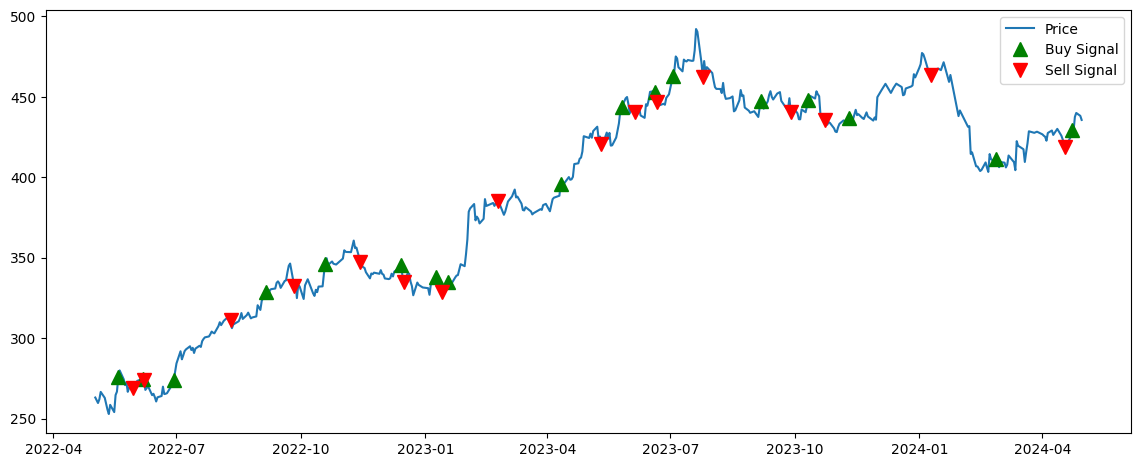

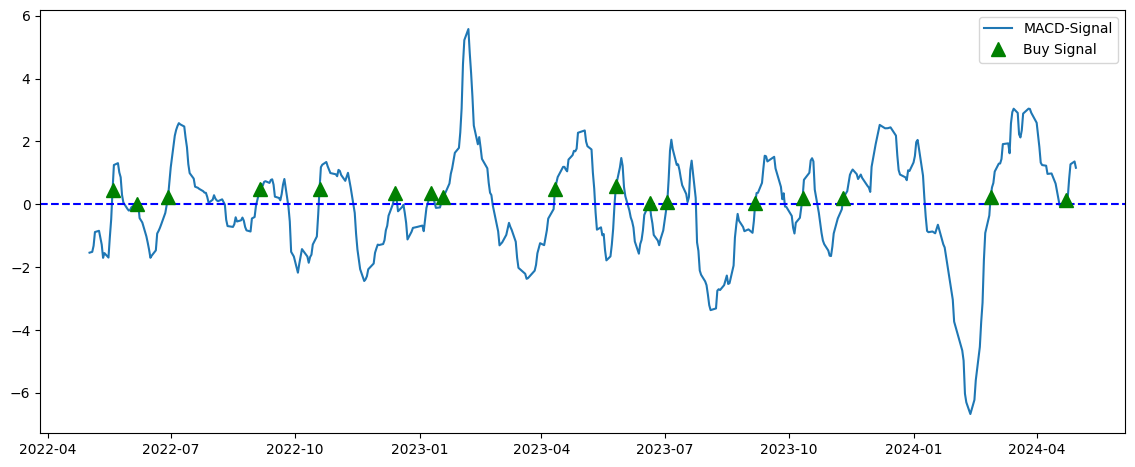

In [23]:

signals = backtest_strategy(prices, hist)
plot_signals(signals)
plt.figure(figsize=(14, 5.5))
plt.plot(signals['hist'], label='MACD-Signal')
plt.axhline(y=0, color='b', linestyle='--')
plt.plot(signals[signals['positions'] == 1].index, signals['hist'][signals['positions'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.legend()
plt.show()



Here we have used each indicator separately and visualised how would we execute trades using them.